In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from confidence_interval import (
    calculate_confidence_interval,
    compare_model_accuracies,
    logo_cv_confidence_interval,
)

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

| Architecture | Simple1d | Simple1dEmbedding | Simple2d | Simple2dEmbedding | ResNet50 | ResNet50Embedding |
| ------------ | ------------: | ------------: | ------------: | ------------: | ------------: | ------------: |
| m68k | 0.174±0.315 | 0.094±0.202 | 0.000±0.000 | 0.014±0.038 | 0.024±0.017 | 0.013±0.015 |
| sh4 | 0.243±0.281 | 0.861±0.221 | 0.199±0.221 | 0.729±0.357 | 0.124±0.077 | 0.644±0.165 |
| hppa | 0.491±0.312 | 0.717±0.261 | 0.121±0.042 | 0.729±0.146 | 0.441±0.129 | 0.591±0.207 |
| s390 | 0.010±0.030 | 0.997±0.005 | 0.004±0.001 | 0.995±0.008 | 0.188±0.400 | 0.951±0.032 |
| arm64 | 0.777±0.251 | 0.791±0.207 | 0.365±0.134 | 0.581±0.287 | 0.200±0.098 | 0.547±0.309 |
| riscv64 | 0.426±0.165 | 0.777±0.287 | 0.246±0.182 | 0.585±0.346 | 0.508±0.076 | 0.730±0.359 |
| ia64 | 0.604±0.488 | 0.792±0.283 | 0.060±0.070 | 0.662±0.423 | 0.715±0.259 | 0.494±0.327 |
| mips | 0.178±0.189 | 0.972±0.035 | 0.352±0.143 | 0.946±0.071 | 0.226±0.121 | 0.673±0.180 |
| s390x | 0.532±0.331 | 1.000±

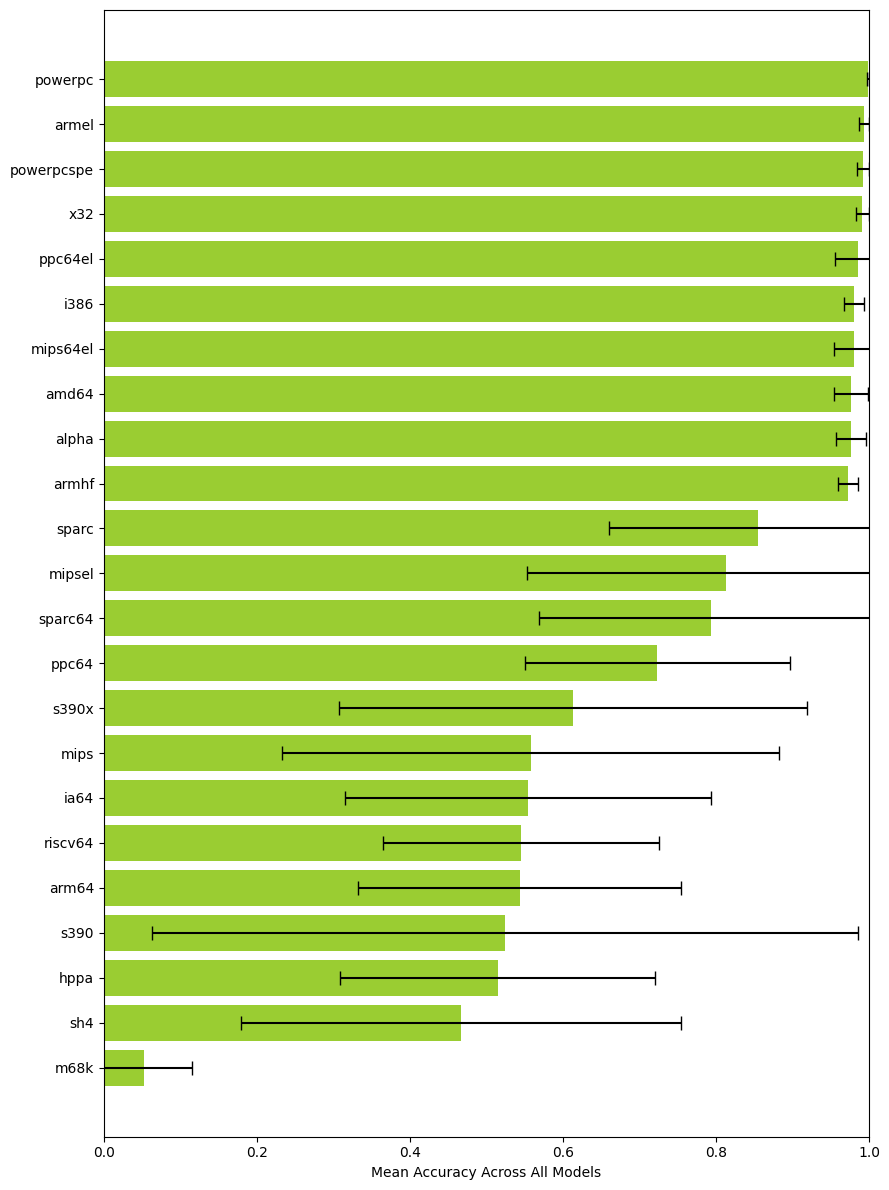

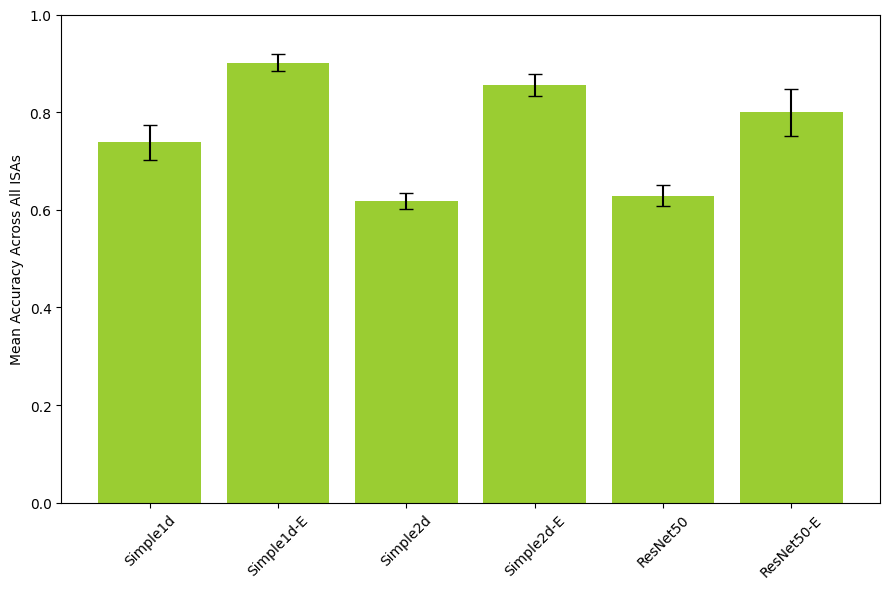

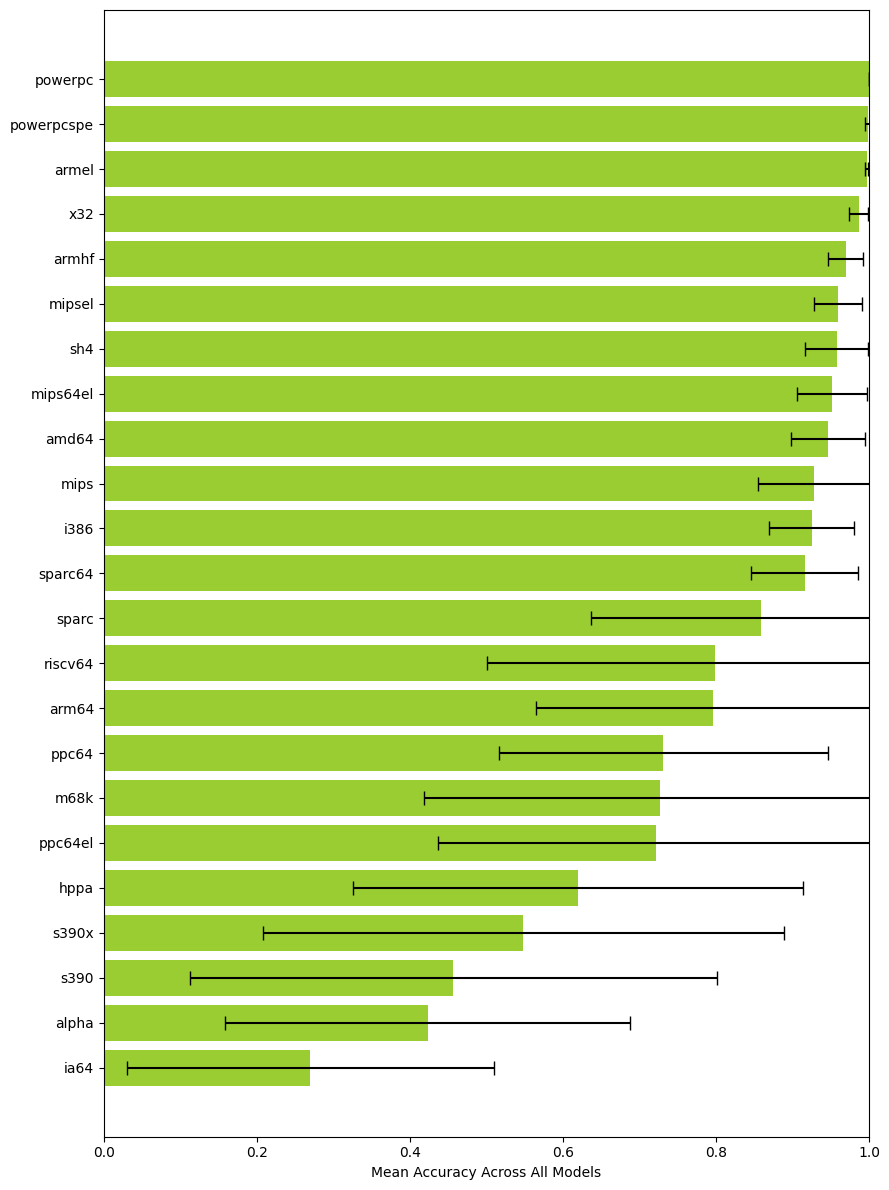

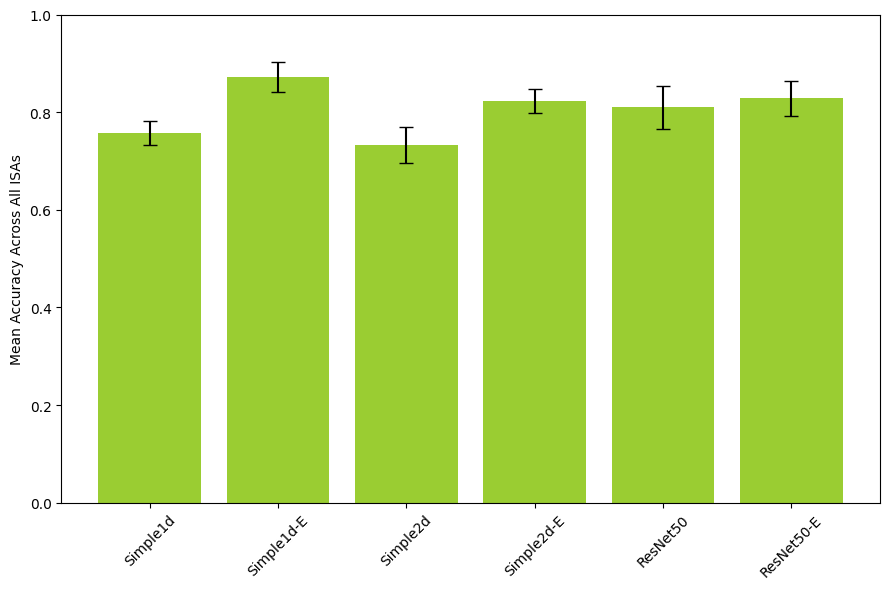

In [2]:
# Specify the directory containing the CSV files
directory = "./input/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "LOGO-*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    # Create a dictionary to store results for each model
    model_results = {}
    model_overall_results = {}

    # Get all unique architectures across all models
    all_architectures = set()

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        # Filter out rows with Name "overall_metrics"
        df_filtered = df[df["Name"] != "overall_metrics"]

        # Group by the seed column and create a list of accuracies
        accuracy_lists = (
            df_filtered.groupby("validator.seed")["test_accuracy_chunk"]
            .apply(list)
            .tolist()
        )

        # Group by the seed column and create a list of dataset sizes
        # fold_sample_counts = (
        #     df_filtered.groupby("validator.seed")["test_dataset_size"]
        #     .apply(list)
        #     .tolist()
        # )
        # TODO: fix when test_dataset_size is implemented
        fold_sample_counts = [[3500 for _ in sublist] for sublist in accuracy_lists]

        # Get overall metrics
        overall_mean, overall_conf_95, _, _ = logo_cv_confidence_interval(
            all_run_fold_accuracies=accuracy_lists,
            fold_sample_counts=fold_sample_counts,
            confidence=0.95,
        )

        model_overall_results[model_name] = (overall_mean, overall_conf_95)

        # Get per-architecture metrics
        df_filtered = df[["Name", "test_accuracy_file", "test_loss", "train_loss"]]
        df_folds = df_filtered[df_filtered["Name"] != "overall_metrics"].rename(
            columns={"Name": "architecture"}
        )
        df_folds["architecture"] = df_folds["architecture"].str.removeprefix("fold_")

        df_agg = (
            df_folds.groupby("architecture")
            .agg({"test_accuracy_file": ["mean", "std"]})
            .reset_index()
        )

        # Store results and collect architectures
        model_results[model_name] = {
            arch: (mean, std)
            for arch, mean, std in zip(
                df_agg["architecture"],
                df_agg[("test_accuracy_file", "mean")],
                df_agg[("test_accuracy_file", "std")],
            )
        }
        all_architectures.update(df_agg["architecture"])

    # Calculate mean accuracy across models for each architecture
    arch_means = {}
    for arch in all_architectures:
        values = []
        for model in model_names:
            if arch in model_results[model]:
                values.append(model_results[model][arch][0])
        arch_means[arch] = np.mean(values)

    # Sort architectures by mean accuracy (descending)
    sorted_architectures = sorted(
        all_architectures, key=lambda x: arch_means[x], reverse=False
    )

    # Create the combined table
    table_string = "| Architecture |"
    for model in model_names:
        table_string += f" {model} |"
    table_string += "\n| ------------ |"
    table_string += " ------------: |" * len(model_names)
    table_string += "\n"

    # Add rows for each architecture
    for arch in sorted_architectures:
        table_string += f"| {arch} |"
        for model in model_names:
            if arch in model_results[model]:
                mean, std = model_results[model][arch]
                table_string += f" {mean:.3f}±{std:.3f} |"
            else:
                table_string += " - |"
        table_string += "\n"

    # Add overall row
    table_string += "| **Overall** |"
    for model in model_names:
        mean, conf_95 = model_overall_results[model]
        table_string += f" **{mean:.3f}±{conf_95:.3f}** |"
    table_string += "\n"

    # Save the table
    filename = (
        f"output/logo-{target_feature.replace('_', '').lower()}-combined-results.md"
    )
    with open(filename, "w") as f:
        f.write(table_string)

    print(table_string)

    # Create horizontal bar chart aggregated by architecture
    plt.figure(figsize=(9, 12))
    arch_means = []
    arch_stds = []

    for arch in sorted_architectures:
        arch_values = []
        for model in model_names:
            if arch in model_results[model]:
                arch_values.append(model_results[model][arch][0])
        arch_means.append(np.mean(arch_values))
        arch_stds.append(np.std(arch_values))

    bars = plt.barh(
        range(len(sorted_architectures)),
        arch_means,
        xerr=arch_stds,
        capsize=5,
        color="yellowgreen",
    )
    plt.yticks(range(len(sorted_architectures)), sorted_architectures)
    plt.xlabel("Mean Accuracy Across All Models")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig(f"output/logo-{target_feature.replace('_', '').lower()}-by-isa.png")

    # Create bar chart aggregated by model
    plt.figure(figsize=(9, 6))
    model_means = []
    model_conf_95s = []

    for model in model_names:
        mean, conf_95 = model_overall_results[model]
        model_means.append(mean)
        model_conf_95s.append(conf_95)

    xticks = [model.replace("Embedding", "-E") for model in model_names]

    bars = plt.bar(
        range(len(model_names)),
        model_means,
        yerr=model_conf_95s,
        capsize=5,
        color="yellowgreen",
    )
    plt.xticks(range(len(model_names)), xticks, rotation=45)
    plt.ylabel("Mean Accuracy Across All ISAs")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"output/logo-{target_feature.replace('_', '').lower()}-by-model.png")